# Deploying Drift Detection

TorchDrift provides the tools you need to detect drift. But how do you actually get your model to monitor drift?

This short tutorial shows how to use model hooks on your feature extractor to capture data to feed into the drift detector.

First we need to set up a model and drift detector. Let us import some packages.

In [5]:
import sys
sys.path.insert(0, '../')

import torch
import torchvision
import torchdrift
import copy
%matplotlib inline
from matplotlib import pyplot

device = "cuda" if torch.cuda.is_available else "cpu"

We use a very simple ResNet as our example model. As we often do, we move the normalization out of the dataset transforms. We do this because we want to post-process the images to "fake" drifted inputs, so you would not need to do this for your own data and models (but I would advocate that moving the normalization into the models is indeed uncommon but best practice). We also split out the fully connected layer from the ResNet.

In [6]:
resnet = torchvision.models.resnet18(pretrained=True)
model = torch.nn.Sequential(
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    resnet,
    resnet.fc
    )
resnet.fc = torch.nn.Identity()
model.eval().to(device)
for p in model.parameters():
    p.requires_grad_(False)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


And we set up a dataset. 

In [7]:
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])


ds_train = torchvision.datasets.ImageFolder('./data/hymenoptera_data/train/',
                                            transform=val_transform)
ds_val = torchvision.datasets.ImageFolder('./data/hymenoptera_data/val/',
                                          transform=val_transform)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=64, shuffle=True)

We fit the detector. We use the p-value here for demonstration. Note that this is currently computationally more expensive than the score (but we'll work on pre-computing the score distribution under the null hypothesis).

In [8]:
def fit_detector(N_train):
    detector = torchdrift.detectors.KernelMMDDriftDetector(return_p_value=True)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=N_train, shuffle=True)
    feature_extractor = model[:2]  # without the fc layer    
    torchdrift.utils.fit(dl_train, feature_extractor, detector, num_batches=1)
    return detector

detector = fit_detector(N_train = 100)

100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


We build a model monitor: When it hooks into the model to capture the output of `feature_layer`. I will cache the last `N` captured model features in a ring buffer.

If we provide a `callback`, it will call the drift detector every `callback_interval` after it has seen enough samples.

Just to show off, I also throw in a little plot function.

In [9]:
class ModelMonitor:
    def __init__(self, drift_detector, feature_layer, N = 20, callback = None, callback_interval = 1):
        self.N = N
        base_outputs = drift_detector.base_outputs
        self.drift_detector = drift_detector
        assert base_outputs is not None, "fit drift detector first"
        feature_dim = base_outputs.size(1)
        self.feature_rb = torch.zeros(N, feature_dim, device=base_outputs.device, dtype=base_outputs.dtype)
        self.have_full_round = False
        self.next_idx = 0
        self.hook = feature_layer.register_forward_hook(self.collect_hook)
        self.counter = 0
        self.callback = callback
        self.callback_interval = callback_interval

    def unhook(self):
        self.hook.remove()

    def collect_hook(self, module, input, output):
        self.counter += 1
        bs = output.size(0)
        if bs > self.N:
            output = output[-self.N:]
            bs = self.N
        output = output.reshape(bs, -1)
        first_part = min(self.N - self.next_idx, bs)
        self.feature_rb[self.next_idx: self.next_idx + first_part] = output[:first_part]
        if first_part < bs:
            self.feature_rb[: bs - first_part] = output[first_part:]
        if not self.have_full_round and self.next_idx + bs >= self.N:
            self.have_full_round = True
        self.next_idx = (self.next_idx + bs) % self.N
        if self.callback and self.have_full_round and self.counter % self.callback_interval == 0:
            p_val = self.drift_detector(self.feature_rb)
            self.callback(p_val)

    def plot(self):
        import sklearn.manifold
        from matplotlib import pyplot
        
        mapping = sklearn.manifold.Isomap()
        ref = mapping.fit_transform(self.drift_detector.base_outputs.to("cpu").numpy())

        test = mapping.transform(self.feature_rb.to("cpu").numpy())
        pyplot.scatter(ref[:, 0], ref[:, 1])
        pyplot.scatter(test[:, 0], test[:, 1])

To instantiate our monitor, we need an alarm function.
I just raise an exception, but you could also text the AI facility management or so.


In [10]:
def alarm(p_value):
    assert p_value > 0.01, f"Drift alarm! p-value: {p_value*100:.03f}%"
    
mm = ModelMonitor(detector, model[1], callback=alarm)

We grab a batch each of benign and drifted samples.

Fun fact: For this dataset, shuffling in the dataloader is important here. Otherwise the class balance of the test batch will be off enough to cause the alarm to be set off.


In [11]:
it = iter(dl_val)
batch = next(it)[0].to(device)
batch_drifted = torchdrift.data.functional.gaussian_blur(next(it)[0].to(device), 5)

Now we run our model. Imagenet class 309 is _bee_ and 310 is _ant_. Do not believe the model if it says aircraft carrier (it did this during testing). Note that we might be unlucky and get an exception here. This is at least in part a sampling artifact from computing the p-value.

In [12]:
res = model(batch).argmax(1) 
res

tensor([310, 310, 309, 310, 301, 309, 310, 985, 494, 114, 309, 310, 309, 310,
        315, 323, 309, 305, 309, 309, 310, 309, 939, 310, 310, 309, 309, 310,
        310, 310, 309, 947, 310, 730, 309, 310, 306, 310, 309, 310, 310, 677,
        309, 324, 410, 309, 309, 309, 306, 309, 304, 310, 309, 309, 309, 946,
        309, 309,  70, 309, 310, 309, 309, 984], device='cuda:0')

In [13]:
detector.compute_p_value(mm.feature_rb)

tensor(0.0230, device='cuda:0')

We can also look at the latents to form an opinion if we think they might be from the same distribution. If you happen to have a heavily class-imbalanced sample (e.g. you disabled the shuffle in the dataloader - for testing, not because you forgot!) you might spot that imbalance here on the projected features.

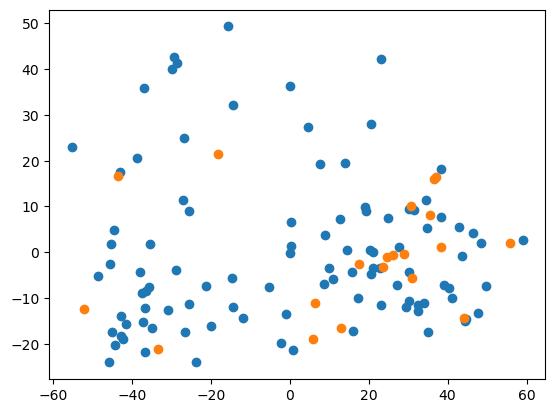

In [14]:
mm.plot()

When we call the model with drifted inputs, we are relatively sure to set off the alarm.

In [15]:
# call it with drifted inputs...
model(batch_drifted)

AssertionError: Drift alarm! p-value: 0.000%

With any luck, you can also see the drift in the datapoints.

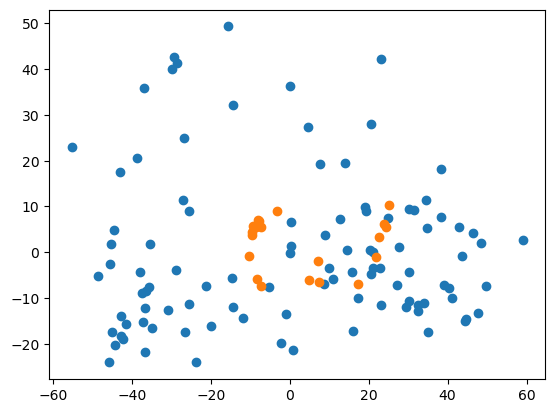

In [16]:
mm.plot()

So in this notebook we saw how to use model hooks with the drift detector to automatically set of the alarm when something bad happens. Just remember that if you set the p-value to $x\%$ you expect to get a false alarm every $100\%/x\%$ batches to not spam your emergency contact.